In [2]:
#✅ STEP 1 — Loading, alignment, basic validation, library-size QC, and provenance saving

# --- Setup --------------------------------------------------------------
suppressPackageStartupMessages({
  library(readr)
  library(dplyr)
  library(tibble)
  library(stringr)
  library(vsn)
  library(DESeq2)
  library(ggplot2)
  library(pheatmap)
  library(reshape2)
})

getwd()
list.files("../data/processed")
# Paths (adjust if yours differ)
counts_path <- "../data/processed/expression_matrix_aligned.csv"
meta_path   <- "../data/processed/design_matrix.csv"

[1] "e:/T2D_Drug_Target_Discovery/notebooks"

[1] "counts_filtered.csv"           "counts_synced.csv"            
 [3] "dds_phase4_raw.rds"            "design_matrix.csv"            
 [5] "design_matrix_synced.csv"      "expression_matrix.csv"        
 [7] "expression_matrix_aligned.csv" "expression_matrix1.csv"       
 [9] "sample_metadata.csv"           "vsd_phase4.rds"               
[11] "vst_matrix.csv"

In [3]:
# --- Load metadata ------------------------------------------------------
meta <- read_csv(meta_path, show_col_types = FALSE) |>
  filter(!is.na(Sample)) |>
  mutate(
    Sample    = as.character(Sample),
    Treatment = factor(Treatment, levels = c("Control","Insulin Resistant")),
    Oxygen    = factor(Oxygen,    levels = c("Normoxia","Hypoxia")),
    Replicate = factor(Replicate),
    Group     = factor(Group, levels = c("CN", "CH", "IRN", "IRH"))
  )

# Quick peek
print(dim(meta))
print(head(meta, 3))

[1] 20  5
# A tibble: 3 × 5
  Sample     Treatment Oxygen  Replicate Group
  <chr>      <fct>     <fct>   <fct>     <fct>
1 GSM8773456 Control   Hypoxia 1         CH   
2 GSM8773457 Control   Hypoxia 2         CH   
3 GSM8773458 Control   Hypoxia 3         CH   


In [4]:
# --- Load counts --------------------------------------------------------
# We expect a 'gene' column then 20 sample columns.
counts_df <- read_csv(counts_path, show_col_types = FALSE)
print(counts_df)

# Ensure 'gene' column exists
stopifnot("gene" %in% colnames(counts_df))

# Make gene names the rownames
counts_df <- counts_df |> relocate(gene)
print(head(counts_df, 4))

gene_ids <- counts_df$gene
print(head(gene_ids, 10))

counts_mat <- counts_df |> select(-gene) |> as.data.frame()
print(head(counts_mat,4))

# A tibble: 62,266 × 21
   gene        GSM8773456 GSM8773457 GSM8773458 GSM8773459 GSM8773460 GSM8773461
   <chr>            <dbl>      <dbl>      <dbl>      <dbl>      <dbl>      <dbl>
 1 5_8S_rRNA            0          0          0          0          0          0
 2 5_8S_rRNA_2          0          0          0          0          0          0
 3 5_8S_rRNA_3          0          0          0          0          0          0
 4 5_8S_rRNA_4          0          0          0          0          0          0
 5 5_8S_rRNA_6          0          0          0          0          0          0
 6 5S_rRNA              0          0          0          0          0          0
 7 5S_rRNA_2            0          0          0          0          0          0
 8 5S_rRNA_4            0          0          0          0          0          0
 9 5S_rRNA_5            0          0          0          0          0          0
10 5S_rRNA_6            0          0          0          0          0          0
# ℹ 

In [5]:
# Ensure columns are exactly the samples in metadata (order might differ)
# First: check sets are equal
stopifnot(setequal(colnames(counts_mat), meta$Sample))

# 1. Check column names == sample IDs
stopifnot(identical(colnames(counts_mat), meta$Sample))
cat("✅ Column names perfectly match metadata order\n")

# 2. Spot check a few values before vs after reorder
# Let's say you saved the original counts before reordering
# (just for validation)
# Save original before reordering
counts_before <- counts_mat  
cat("\n🔍 Last 3 rows before reordering:\n")
print(tail(counts_before, 3))

# Reorder columns to match metadata
counts_mat <- counts_mat[, meta$Sample, drop = FALSE]

# Validation: check last 3 samples (from metadata)
last3_samples <- tail(meta$Sample, 3)

# ✅ Check last 3 samples
for (s in last3_samples) {   
  cat("\nSample:", s, "\n")
  cat("Same across all genes? ", all(counts_before[, s] == counts_mat[, s]), "\n")
}

# Also print last 3 rows of counts to cross-check
cat("\n🔍 Last 3 rows after reordering:\n")
print(tail(counts_mat, 3))

✅ Column names perfectly match metadata order

🔍 Last 3 rows before reordering:
      GSM8773456 GSM8773457 GSM8773458 GSM8773459 GSM8773460 GSM8773461
62264          0          0          0          0          0          0
62265       1735       1312       1382       1291       1352       1522
62266       1030        947        946       1274       1035        934
      GSM8773462 GSM8773463 GSM8773464 GSM8773465 GSM8773466 GSM8773467
62264          0          0          0          0          0          0
62265       1835       1651       1512       1763       1653       1152
62266        794        630        676        629        870       1011
      GSM8773468 GSM8773469 GSM8773470 GSM8773471 GSM8773472 GSM8773473
62264          0          0          0          0          0          0
62265       1582       1827       1835       1723       1696       1606
62266        817        885        807        837        520        685
      GSM8773474 GSM8773475
62264          0          0


In [6]:
# --- Hard sanity checks -------------------------------------------------
# 1) All non-negative?
stopifnot(all(counts_mat >= 0, na.rm = TRUE))

# 2) Integers? (DESeq2 requires integer counts)
is_integer_like <- function(x) all(!is.na(x)) && all(abs(x - round(x)) < 1e-8)
all_integer <- all(vapply(counts_mat, is_integer_like, logical(1)))
stopifnot(all_integer)

print(all_integer)

# 3) No missing values?
stopifnot(!any(is.na(counts_mat)))

# 4) Row/col names set properly
rownames(counts_mat) <- gene_ids
print(head(rownames(counts_mat), 5))
stopifnot(!anyDuplicated(rownames(counts_mat)))

# 5) Basic dimensions + head
cat("Counts dim (genes x samples): ", paste(dim(counts_mat), collapse=" x "), "\n")
cat("Meta dim (samples x cols): ", paste(dim(meta), collapse=" x "), "\n")

[1] TRUE
[1] "5_8S_rRNA"   "5_8S_rRNA_2" "5_8S_rRNA_3" "5_8S_rRNA_4" "5_8S_rRNA_6"
Counts dim (genes x samples):  62266 x 20 
Meta dim (samples x cols):  20 x 5 


In [7]:
# --- Quick library sizes ------------------------------------------------
lib_sizes <- colSums(counts_mat)
lib_tbl <- tibble(Sample = names(lib_sizes), LibrarySize = as.numeric(lib_sizes)) |>
  left_join(meta, by = "Sample") |>
  arrange(Sample)

print(head(lib_tbl, 10))
summary(lib_tbl$LibrarySize)

# --- Save a synced copy for provenance ---------------------------------
dir.create("../data/processed", showWarnings = FALSE, recursive = TRUE)
write_csv(meta, "../data/processed/design_matrix_synced.csv")
write_csv(
  tibble(gene = rownames(counts_mat)) |> bind_cols(as_tibble(counts_mat)),
  "../data/processed/counts_synced.csv"
)

cat("✅Step 1 complete: inputs loaded, aligned, and validated.\n")

# A tibble: 10 × 6
   Sample     LibrarySize Treatment Oxygen   Replicate Group
   <chr>            <dbl> <fct>     <fct>    <fct>     <fct>
 1 GSM8773456    24433027 Control   Hypoxia  1         CH   
 2 GSM8773457    22460460 Control   Hypoxia  2         CH   
 3 GSM8773458    23413291 Control   Hypoxia  3         CH   
 4 GSM8773459    25870672 Control   Hypoxia  4         CH   
 5 GSM8773460    23604335 Control   Hypoxia  5         CH   
 6 GSM8773461    28287574 Control   Normoxia 1         CN   
 7 GSM8773462    27561534 Control   Normoxia 2         CN   
 8 GSM8773463    26250529 Control   Normoxia 3         CN   
 9 GSM8773464    25510508 Control   Normoxia 4         CN   
10 GSM8773465    27065655 Control   Normoxia 5         CN   


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
22460460 24623921 26177575 26210133 28026363 30304175 

✅Step 1 complete: inputs loaded, aligned, and validated.


In [8]:
# ✅STEP 2: De-duplicate, drop all-zero, and filter low-count genes

# 0. record starting number of genes
n_genes_start <- nrow(counts_mat)
cat("Starting genes:", n_genes_start, "\n")

# 1) Handle duplicated gene IDs (if any)
dup_genes_vector <- duplicated(rownames(counts_mat))
cat("Number of duplicated gene IDs:", sum(dup_genes_vector), "\n")
cat("First 5 duplicated gene vector rows:", head(dup_genes_vector, 5), "\n")

dup_genes <- rownames(counts_mat)[duplicated(rownames(counts_mat))]
cat("Number of duplicated gene IDs:", length(dup_genes), "\n")

if (length(dup_genes) > 0) {
  # Simple resolution: collapse duplicates by summing counts across duplicated rows
  counts_mat <- as.data.frame(counts_mat) |>
    tibble::rownames_to_column(var = "gene") |>
    group_by(gene) |>
    summarise(across(-gene, ~ sum(.x, na.rm = TRUE))) |>
    tibble::column_to_rownames(var = "gene")
  cat("Collapsed duplicated gene IDs by summing counts. New gene count:", nrow(counts_mat), "\n")
}


print(head(counts_mat),5)
print(class(counts_mat))

#deep check for the chunck from potential duplicate if block
x <- tibble::rownames_to_column(as.data.frame(counts_mat), var = "gene") |> group_by(gene)
print((x))



Starting genes: 62266 
Number of duplicated gene IDs: 0 
First 5 duplicated gene vector rows: FALSE FALSE FALSE FALSE FALSE 
Number of duplicated gene IDs: 0 
            GSM8773456 GSM8773457 GSM8773458 GSM8773459 GSM8773460 GSM8773461
5_8S_rRNA            0          0          0          0          0          0
5_8S_rRNA_2          0          0          0          0          0          0
5_8S_rRNA_3          0          0          0          0          0          0
5_8S_rRNA_4          0          0          0          0          0          0
5_8S_rRNA_6          0          0          0          0          0          0
5S_rRNA              0          0          0          0          0          0
            GSM8773462 GSM8773463 GSM8773464 GSM8773465 GSM8773466 GSM8773467
5_8S_rRNA            0          0          0          0          0          0
5_8S_rRNA_2          0          0          0          0          0          0
5_8S_rRNA_3          0          0          0          0      

# A tibble: 62,266 × 21
# Groups:   gene [62,266]
   gene        GSM8773456 GSM8773457 GSM8773458 GSM8773459 GSM8773460 GSM8773461
   <chr>            <dbl>      <dbl>      <dbl>      <dbl>      <dbl>      <dbl>
 1 5_8S_rRNA            0          0          0          0          0          0
 2 5_8S_rRNA_2          0          0          0          0          0          0
 3 5_8S_rRNA_3          0          0          0          0          0          0
 4 5_8S_rRNA_4          0          0          0          0          0          0
 5 5_8S_rRNA_6          0          0          0          0          0          0
 6 5S_rRNA              0          0          0          0          0          0
 7 5S_rRNA_2            0          0          0          0          0          0
 8 5S_rRNA_4            0          0          0          0          0          0
 9 5S_rRNA_5            0          0          0          0          0          0
10 5S_rRNA_6            0          0          0          0 

In [9]:
# 2) Drop all-zero genes
row_sum<-rowSums(counts_mat)
all_zero <- row_sum == 0
cat(row_sum, "\n")
cat(all_zero, "\n")
cat("All-zero genes:", sum(all_zero), "\n")
counts_nonzero <- counts_mat[!all_zero, , drop = FALSE]
print(head(counts_nonzero),5)
cat("Genes after dropping all-zero:", nrow(counts_nonzero), "\n")

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3181 5032 1 190885 2234 18 0 0 0 3 13 59583 0 0 21426 23326 470 14 263 0 0 0 1 37 5 2863 20783 45977 8386 40517 94 21684 818 62894 0 10796 10197 36 4608 29186 23356 40 14191 11007 823 32816 14189 120 1135 153 552 35 256 67076 35915 0 31 6861 70 40571 7121 141 3 219 14425 66 156 102 450 5856 2 20880 13521 18823 8281 48178 9286 118 9 0 0 122 1177 7990 50787 0 7071 1086 8 2 670 255 4777 29539 0 0 0 0 148 35122 15027 29605 40218 17530 6399 0 0 26762 1866 199 1205 0 0 209 13167 7694 28239 6 11993 7306 421 5622 6006 0 17335 228 49829 3 7 0 0 5 0 0 0 7954 2085 20078 41266 2225 19486 9130 3968 10375 19621 0 57751 98 149 5748 0 51959 12286 212706 2103 6757 248 68118 0 2943 3094 4518 0 0 10192 11221 0 5441 41878 4184 31974 69399 227 28792 45606 17967 18111 16556 17367 306 373 38021 20284 16298 202425 6 616 16248 23 38584 26792 14428 40148 3 3735 29649 22304 1573 1645 0 4091 951 22179 18 0 5 1563 0 16500 1455 70749 8 350 11551 154 0 70020 4 0 33049 186246 0 1

In [10]:
# 3) Filter lowly expressed genes
# Threshold: count >= 10 in at least 3 samples (adjust if you want)
# Option A (global filter)
min_count <- 10
min_samples <- 3
keep_mask_A <- rowSums(counts_nonzero >= min_count) >= min_samples
cat("Genes passing filter (≥ ", min_count, " in ≥ ", min_samples, " samples): ", sum(keep_mask_A), "\n", sep = "")
counts_filtered_A <- counts_nonzero[keep_mask_A, , drop = FALSE]
cat("Genes after filtering using Option A (global filter) count >= 10 in at least 3 samples:", nrow(counts_filtered_A), "\n", "\n")

genes_A <- rownames(counts_nonzero)[keep_mask_A]

# Option B (group-aware filter)
groups <- split(colnames(counts_nonzero), meta$Group) # CN, CH, IRN, IRH
print(meta$Group)
cat("list with 4 elements/ conditions (one for each group): ", "\n")
print(groups)
per_group_keep <- lapply(groups, function(cols) { rowSums(counts_nonzero[, cols, drop = FALSE] >= 10) >= 3 })
keep_mask_B <- Reduce(`|`, per_group_keep) # keep if TRUE in any group
cat("Genes passing group-aware filter (≥10 in ≥3 samples within a group):", sum(keep_mask_B), "\n")
counts_filtered <- counts_nonzero[keep_mask_B, , drop = FALSE]

cat("Genes after filtering using Option B (group-aware filter: CN, CH, IRN, IRH) :", nrow(counts_filtered), "\n")

genes_B <- rownames(counts_nonzero)[keep_mask_B]

# Compare
lost_genes <- setdiff(genes_A, genes_B)  # genes kept in A but lost in B
cat("Lost Genes: ", length(lost_genes))
head(lost_genes, 10)
counts_nonzero[lost_genes[1:5], ]  # show first 5 lost genes across samples




Genes passing filter (≥ 10 in ≥ 3 samples): 18805
Genes after filtering using Option A (global filter) count >= 10 in at least 3 samples: 18805 
 
 [1] CH  CH  CH  CH  CH  CN  CN  CN  CN  CN  IRH IRH IRH IRH IRH IRN IRN IRN IRN
[20] IRN
Levels: CN CH IRN IRH
list with 4 elements/ conditions (one for each group):  
$CN
[1] "GSM8773461" "GSM8773462" "GSM8773463" "GSM8773464" "GSM8773465"

$CH
[1] "GSM8773456" "GSM8773457" "GSM8773458" "GSM8773459" "GSM8773460"

$IRN
[1] "GSM8773471" "GSM8773472" "GSM8773473" "GSM8773474" "GSM8773475"

$IRH
[1] "GSM8773466" "GSM8773467" "GSM8773468" "GSM8773469" "GSM8773470"

Genes passing group-aware filter (≥10 in ≥3 samples within a group): 18090 
Genes after filtering using Option B (group-aware filter: CN, CH, IRN, IRH) : 18090 
Lost Genes:  715

[1] "ABCA12"    "ABCA9"     "ABCC11"    "ABCD2"     "ACSL6"     "ADAMTS4"  
 [7] "ADAMTS7P1" "ADM5"      "AFTPH-DT"  "AGAP11"

,GSM8773456,GSM8773457,GSM8773458,GSM8773459,GSM8773460,GSM8773461,GSM8773462,GSM8773463,GSM8773464,GSM8773465,GSM8773466,GSM8773467,GSM8773468,GSM8773469,GSM8773470,GSM8773471,GSM8773472,GSM8773473,GSM8773474,GSM8773475
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ABCA12,9,4,4,7,6,11,12,9,7,9,2,4,3,12,5,10,5,21,8,5
ABCA9,5,3,4,15,10,4,13,8,9,8,4,2,13,0,5,6,4,6,11,11
ABCC11,12,5,3,8,6,11,8,0,7,11,6,6,5,3,2,8,2,4,8,3
ABCD2,1,3,6,0,5,14,11,9,5,7,9,9,5,9,7,8,5,8,9,18
ACSL6,5,3,6,11,7,5,10,3,5,7,7,5,19,8,11,4,12,10,9,4


In [11]:
# 4) Save Group aware filtered counts for provenance
dir.create("../data/processed", showWarnings = FALSE, recursive = TRUE)
write.csv(
  tibble::rownames_to_column(as.data.frame(counts_filtered), var = "gene"),
  file = "../data/processed/counts_filtered.csv",
  row.names = FALSE
)

# print a small snapshot
cat("\nSnapshot (first 4 genes):\n")
print(head(counts_filtered, 4))

# Report reduction
cat("\nSummary of Reduction:\n")
cat("Start:", n_genes_start, "-> After removing all-zero:", nrow(counts_nonzero), "-> After Group aware filtering:", nrow(counts_filtered), "\n")
cat("✅Step 2 complete:  De-duplicate, drop all-zero, and filter low-count genes.\n")





Snapshot (first 4 genes):
         GSM8773456 GSM8773457 GSM8773458 GSM8773459 GSM8773460 GSM8773461
A1BG            138        174        133        169        159        157
A1BG-AS1        198        167        166        135        175        364
A2M           11620       8951       8980       9751      10198      14041
A2M-AS1         102         74         54         49         86        100
         GSM8773462 GSM8773463 GSM8773464 GSM8773465 GSM8773466 GSM8773467
A1BG            214        160        142        128        179        216
A1BG-AS1        313        253        269        290        268        281
A2M           10784       9220       9116      11247       8186       6922
A2M-AS1         115        112        114        117        168        162
         GSM8773468 GSM8773469 GSM8773470 GSM8773471 GSM8773472 GSM8773473
A1BG            166        139        204        104        149        136
A1BG-AS1        240        268        280        227        312        23

In [12]:
#Load the saved processed files & re-check alignment (sanity)

# paths
counts_filt_path <- "../data/processed/counts_filtered.csv"
meta_path        <- "../data/processed/design_matrix_synced.csv"

# load
meta <- read_csv(meta_path, show_col_types = FALSE) %>%
  filter(!is.na(Sample)) %>%
  mutate(
    Sample    = as.character(Sample),
    Treatment = factor(Treatment, levels = c("Control","Insulin Resistant")),
    Oxygen    = factor(Oxygen, levels = c("Normoxia","Hypoxia")),
    Replicate = factor(Replicate),
    Group     = factor(Group, levels = c("CN","CH","IRN","IRH"))
  )

counts_df <- read_csv(counts_filt_path, show_col_types = FALSE)
stopifnot("gene" %in% colnames(counts_df))
gene_ids <- counts_df$gene
counts_mat <- counts_df %>% select(-gene) %>% as.data.frame()
rownames(counts_mat) <- gene_ids

# checks
cat("counts dims:", dim(counts_mat), "\n")
cat("meta rows:", nrow(meta), "\n")
if (!identical(colnames(counts_mat), meta$Sample)) {
  # reorder if necessary
  if (setequal(colnames(counts_mat), meta$Sample)) {
    counts_mat <- counts_mat[, meta$Sample, drop=FALSE]
    cat("Reordered count columns to match meta.\n")
  } else {
    stop("Column names in counts and meta$Sample differ (not setequal). Inspect names.")
  }
}
# integer-ish check
is_integer_like <- function(x) all(!is.na(x)) && all(abs(x - round(x)) < 1e-8)
all_integer <- all(vapply(as.data.frame(counts_mat), is_integer_like, logical(1)))
cat("All values integer-like? ", all_integer, "\n")
# missing / negatives
cat("Any NAs?", any(is.na(counts_mat)), "\n")
cat("Any negatives?", any(counts_mat < 0), "\n")

# quick glance
print(dim(counts_mat))
print(head(counts_mat[,1:6]))
print(table(meta$Group))

cat("✅Step 3 complete:  Load the saved processed files & re-check alignment (sanity integer-ish check, missing / negatives / quick glance)\n")


counts dims: 18090 20 
meta rows: 20 
All values integer-like?  TRUE 
Any NAs? FALSE 
Any negatives? FALSE 
[1] 18090    20
         GSM8773456 GSM8773457 GSM8773458 GSM8773459 GSM8773460 GSM8773461
A1BG            138        174        133        169        159        157
A1BG-AS1        198        167        166        135        175        364
A2M           11620       8951       8980       9751      10198      14041
A2M-AS1         102         74         54         49         86        100
A4GALT         2510       2053       1928       1791       1858       2927
AAAS            967        866        854       1064        933       1221

 CN  CH IRN IRH 
  5   5   5   5 
✅Step 3 complete:  Load the saved processed files & re-check alignment (sanity integer-ish check, missing / negatives / quick glance)


In [13]:
.libPaths()

[1] "E:/Rlibs"           "E:/R-4.5.1/library"

In [14]:
if(FALSE){

    if (!requireNamespace("BiocManager", quietly = TRUE))
        install.packages("BiocManager")

    BiocManager::install("vsn", lib = "E:/Rlibs")
    BiocManager::install("reshape2", lib = "E:/Rlibs")
}




In [15]:
#Create DESeqDataSet (dds) and set design

#we are using library(DESeq2)

# ensure counts are matrix and rounded (only if raw counts!)
count_mat <- round(as.matrix(counts_mat))  # rounding small FP noise if present


# create dds
dds <- DESeqDataSetFromMatrix(countData = count_mat,
                              colData = meta,
                              design = ~ Treatment * Oxygen)

# pre-filter rows with zero sums (should already be done)
dds <- dds[rowSums(counts(dds)) > 0, ]

# make sure Control & Normoxia are reference
dds$Treatment <- relevel(dds$Treatment, ref = "Control")
dds$Oxygen    <- relevel(dds$Oxygen, ref = "Normoxia")

# check factor levels and reset reference if needed
levels(dds$Treatment)
levels(dds$Oxygen)

# save the raw dds object for provenance
saveRDS(dds, file = "../data/processed/dds_phase4_raw.rds")
cat("✅Step 4 complete: DDS created. Rows (genes):", nrow(dds), "Cols (samples):", ncol(dds), "\n")


converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



[1] "Control"           "Insulin Resistant"

[1] "Normoxia" "Hypoxia"

✅Step 4 complete: DDS created. Rows (genes): 18090 Cols (samples): 20 


In [16]:
#Size factors and VST (QC-ready transform)

#we are using library(vsn)    # ensures vst available
# estimate size factors (not running DESeq yet)
dds <- estimateSizeFactors(dds)

# VST
vsd <- vst(dds, blind = FALSE)   # blind=FALSE to preserve design info for PCA
# save vsd and vst matrix
saveRDS(vsd, file = "../data/processed/vsd_phase4.rds")
write.csv(assay(vsd), file = "../data/processed/vst_matrix.csv", quote = FALSE)
cat(dim(vsd))
cat("✅Step 5 complete: VST computed and saved.\n")



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



18090 20✅Step 5 complete: VST computed and saved.


using ntop=500 top features by variance



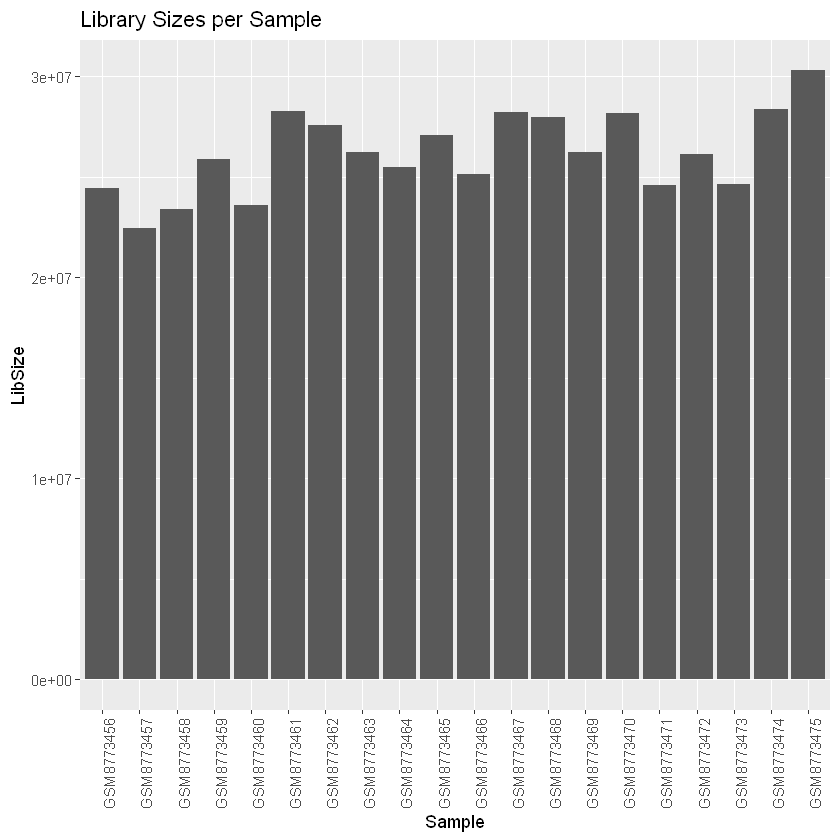

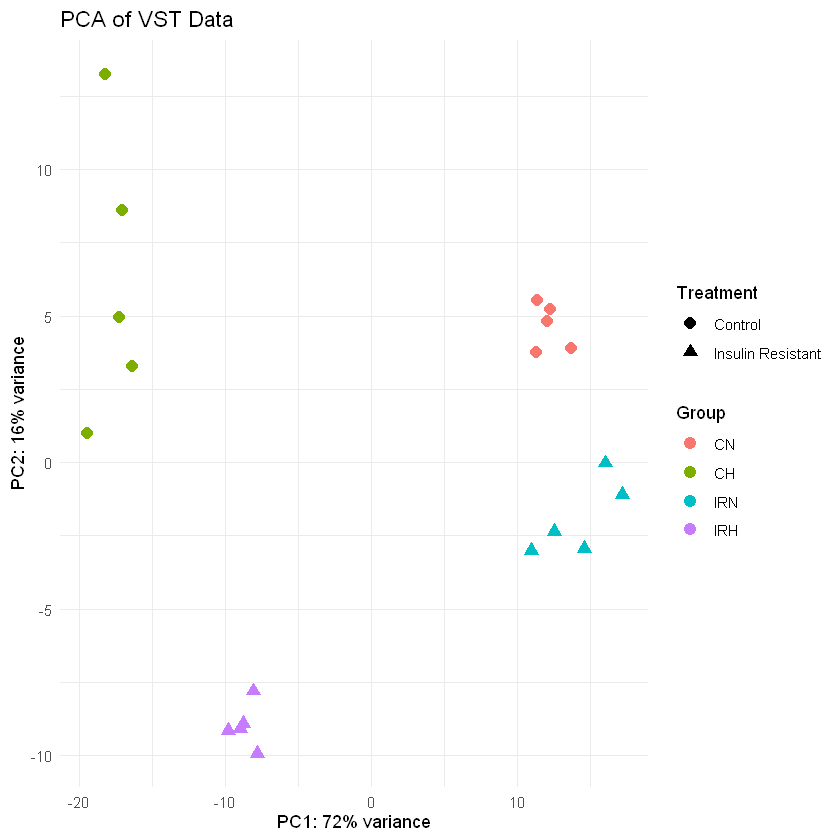

pdf 
  3

✅Step 6 complete: QC plots: library sizes, PCA, sample distance heatmap, boxplots. 


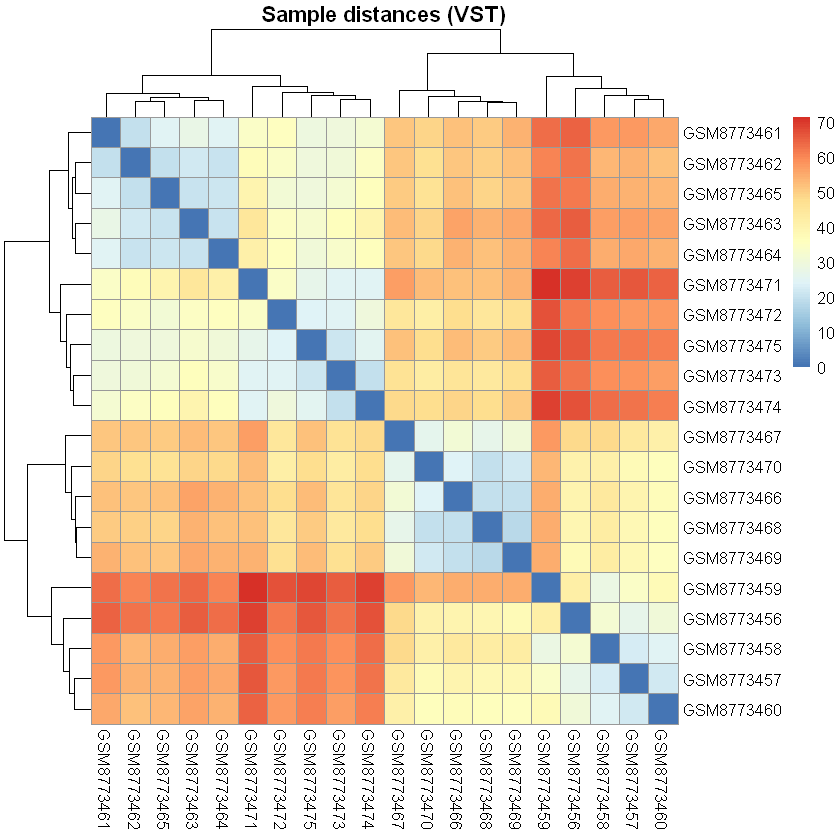

In [17]:
# QC plots: library sizes, PCA, sample distance heatmap, boxplots

# create results/qc folder if missing
if (!dir.exists("../results/qc")) {
  dir.create("../results/qc", recursive = TRUE)
}

# --- Library sizes ---
libsizes <- colSums(counts(dds))
lib_df <- data.frame(Sample = names(libsizes), LibSize = as.numeric(libsizes)) %>%
  left_join(meta, by = c("Sample"="Sample"))

p_lib <- ggplot(lib_df, aes(x = Sample, y = LibSize)) +
  geom_bar(stat="identity") +
  theme(axis.text.x = element_text(angle=90, hjust=1)) +
  ggtitle("Library Sizes per Sample")

print(p_lib)  # show in console
ggsave("../results/qc/library_sizes.png", plot = p_lib, width=10, height=4)

# --- PCA ---
pcaData <- plotPCA(vsd, intgroup = c("Group","Treatment","Oxygen"), returnData = TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))

p_pca <- ggplot(pcaData, aes(PC1, PC2, color = Group, shape = Treatment)) +
  geom_point(size = 3) +
  labs(x = paste0("PC1: ", percentVar[1], "% variance"),
       y = paste0("PC2: ", percentVar[2], "% variance")) +
  theme_minimal() +
  ggtitle("PCA of VST Data")

print(p_pca)
ggsave("../results/qc/pca_group.png", plot = p_pca, width = 6, height = 5)

# --- Sample distances (heatmap) ---
sampleDists <- dist(t(assay(vsd)))
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- colnames(vsd)
colnames(sampleDistMatrix) <- colnames(vsd)

# print AND save heatmap
pheatmap(sampleDistMatrix, main = "Sample distances (VST)")
pheatmap(sampleDistMatrix, filename = "../results/qc/sample_distance_heatmap.png", main = "Sample distances (VST)")

# --- Boxplot of VST values (Base R, fast + saved) ---

# show in console
boxplot(assay(vsd), las = 2, main = "VST per sample", outline = FALSE)

# save to file
png("../results/qc/vst_boxplot.png", width = 1000, height = 600)
boxplot(assay(vsd), las = 2, main = "VST per sample", outline = FALSE)
dev.off()

cat("✅Step 6 complete: QC plots: library sizes, PCA, sample distance heatmap, boxplots. \n")




In [ ]:
# Make sure results/logs exists
if (!dir.exists("../results/logs")) {
  dir.create("../results/logs", recursive = TRUE)
}

# Save to a plain text file
writeLines(capture.output(sessionInfo()), "../results/logs/sessionInfo_phase4.txt")

# OR save as RDS (structured object, not human readable)
#saveRDS(sessionInfo(), "../results/logs/sessionInfo_phase4.rds")
